In [ ]:
import os
# import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
# import seaborn as sn
from sklearn import model_selection
# from sklearn import preprocessing
import IPython.display as ipd
from tqdm import tqdm

## Preparation

In [ ]:
# load a wave data
def load_wave_data(audio_dir, file_name):
    file_path = os.path.join(audio_dir, file_name)
    x, fs = librosa.load(file_path, sr=44100)
    return x,fs

In [ ]:
# change wave data to mel-stft
def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=128)
    return melsp

In [ ]:
# display wave in plots
def show_wave(x):
    plt.plot(x)
    plt.show()

In [ ]:
# display wave in heatmap
def show_melsp(melsp, fs):
    librosa.display.specshow(melsp, sr=fs)
    plt.colorbar()
    plt.show()

In [ ]:
# This values are necessary to create and reshape data arrays
freq = 128
time = 1723

In [ ]:
!kaggle datasets download -d mmoreaux/environmental-sound-classification-50

Dataset URL: https://www.kaggle.com/datasets/mmoreaux/environmental-sound-classification-50
License(s): CC-BY-NC-SA-4.0
100% 1.42G/1.42G [00:19<00:00, 116MB/s] 
100% 1.42G/1.42G [00:19<00:00, 80.2MB/s]


In [ ]:
!unzip /content/environmental-sound-classification-50.zip -d /content/environmental-sound-classification-50/

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/environmental-sound-classification-50/audio/audio/16000/2-188822-C-40.wav  
  inflating: /content/environmental-sound-classification-50/audio/audio/16000/2-188822-D-40.wav  
  inflating: /content/environmental-sound-classification-50/audio/audio/16000/2-196688-A-8.wav  
  inflating: /content/environmental-sound-classification-50/audio/audio/16000/2-205966-A-16.wav  
  inflating: /content/environmental-sound-classification-50/audio/audio/16000/2-209471-A-25.wav  
  inflating: /content/environmental-sound-classification-50/audio/audio/16000/2-209472-A-25.wav  
  inflating: /content/environmental-sound-classification-50/audio/audio/16000/2-209473-A-25.wav  
  inflating: /content/environmental-sound-classification-50/audio/audio/16000/2-209474-A-25.wav  
  inflating: /content/environmental-sound-classification-50/audio/audio/16000/2-209475-A-25.wav  
  inflating: /content/environmental-sound-classification-50/audio/audio/16000/2-209476-A-25.

In [ ]:
# define directories
base_dir = "/content/environmental-sound-classification-50"
esc_dir = os.path.join(base_dir, "ESC-50-master")
meta_file = os.path.join(base_dir, "esc50.csv")
audio_dir = os.path.join(base_dir, "audio/audio/44100/")

In [ ]:
# load metadata
meta_data = pd.read_csv(meta_file)
meta_data

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [ ]:
# get data size
data_size = meta_data.shape
print(data_size)

(2000, 7)


In [ ]:
# arrange target label and its name
class_dict = {}
for i in range(data_size[0]):
    if meta_data.loc[i,"target"] not in class_dict.keys():
        class_dict[meta_data.loc[i,"target"]] = meta_data.loc[i,"category"]
class_pd = pd.DataFrame(list(class_dict.items()), columns=["labels","classes"])
class_pd

,labels,classes
0,0,dog
1,14,chirping_birds
2,36,vacuum_cleaner
3,19,thunderstorm
4,30,door_wood_knock
5,34,can_opening
6,9,crow
7,22,clapping
8,48,fireworks
9,41,chainsaw


## Load dataset

wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


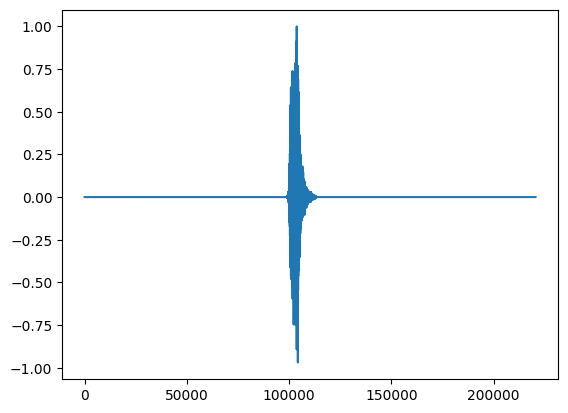

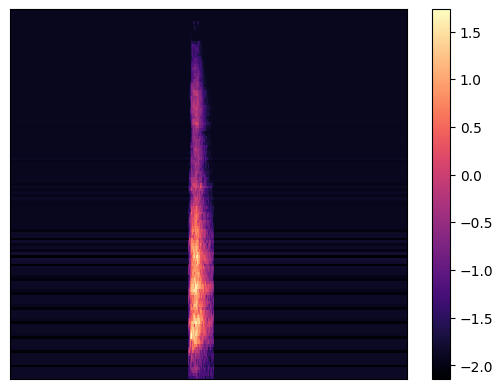

In [ ]:
# example data
x, fs = load_wave_data(audio_dir, meta_data.loc[0,"filename"])
melsp = calculate_melsp(x)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x.shape, melsp.shape, fs))
show_wave(x)
show_melsp(melsp, fs)

In [ ]:
White_noise_rate = 0.002
Shift_rate =  2
Learning_rate = 0.001

In [ ]:
ipd.Audio(x, rate=fs)

In [ ]:
# data augmentation: add white noise
def add_white_noise(x, rate=White_noise_rate):
    return x + rate*np.random.randn(len(x))

wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


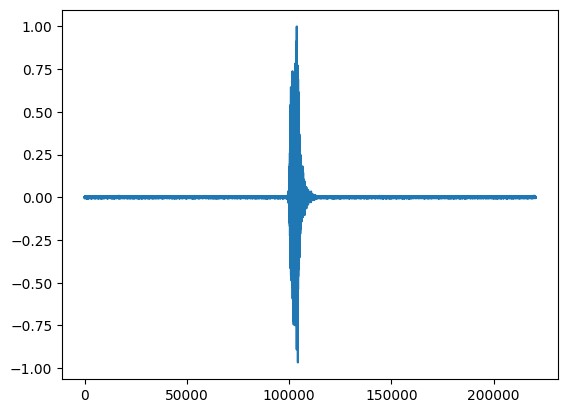

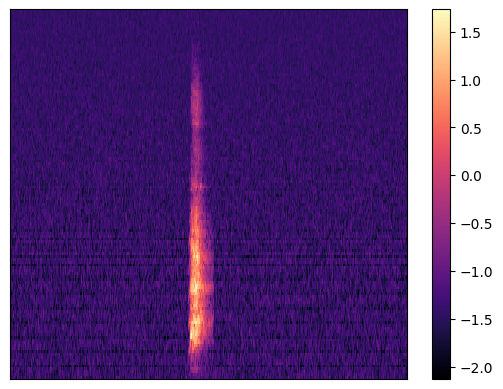

In [ ]:
x_wn = add_white_noise(x)
melsp = calculate_melsp(x_wn)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x_wn.shape, melsp.shape, fs))
show_wave(x_wn)
show_melsp(melsp, fs)

In [ ]:
ipd.Audio(x_wn, rate=fs)

In [ ]:
# data augmentation: shift sound in timeframe
def shift_sound(x, rate=Shift_rate):
    return np.roll(x, int(len(x)//rate))

wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


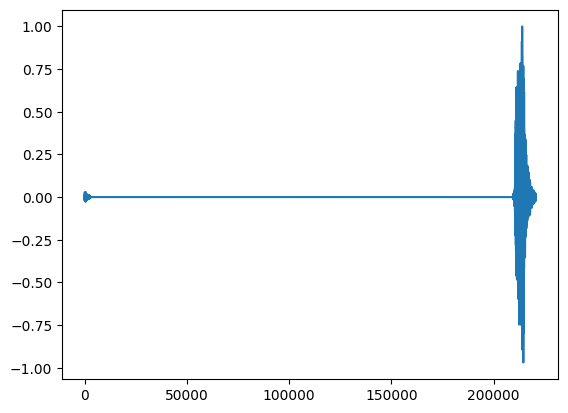

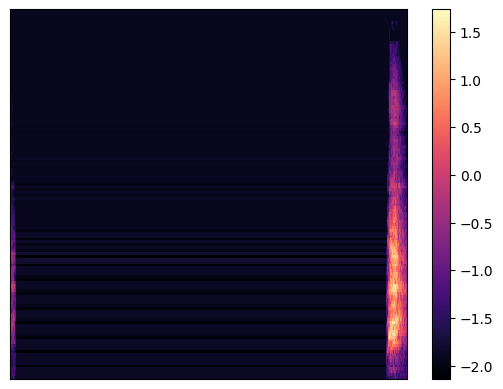

In [ ]:
x_ss = shift_sound(x)
melsp = calculate_melsp(x_ss)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x_ss.shape, melsp.shape, fs))
show_wave(x_ss)
show_melsp(melsp, fs)

In [ ]:
ipd.Audio(x_ss, rate=fs)

In [ ]:
# get training dataset and target dataset
x = list(meta_data.loc[:, "filename"])
y = list(meta_data.loc[:, "target"])

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.25, stratify=y)
print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(len(x_train), len(y_train), len(x_test), len(y_test)))

x train:1500
y train:1500
x test:500
y test:500


In [ ]:
# save wave data in npz, with augmentation
def save_np_data(filename, x, y, aug=None, rates=None):
    np_data = np.zeros(freq*time*len(x)).reshape(len(x), freq, time)
    np_targets = np.zeros(len(y))
    for i in range(len(y)):
        _x, fs = load_wave_data(audio_dir, x[i])
        if aug is not None:
            _x = aug(x=_x, rate=rates[i])
        _x = calculate_melsp(_x)
        np_data[i] = _x
        np_targets[i] = y[i]
    np.savez(filename, x=np_data, y=np_targets)

In [ ]:
# save test dataset
if not os.path.exists("esc_melsp_test.npz"):
    save_np_data("esc_melsp_test.npz", x_test,  y_test)

# !!!
# 下面四个保存训练样本选择第一个和剩下三个中的其中一个执行，全部执行会爆内存

In [ ]:
# save raw training dataset
if not os.path.exists("esc_melsp_train_raw.npz"):
    save_np_data("esc_melsp_train_raw.npz", x_train,  y_train)

In [ ]:
# save training dataset with white noise
if not os.path.exists("esc_melsp_train_wn.npz"):
    rates = np.random.randint(1,50,len(x_train))/10000
    save_np_data("esc_melsp_train_wn.npz", x_train,  y_train, aug=add_white_noise, rates=rates)

In [ ]:
# save training dataset with sound shift
if not os.path.exists("esc_melsp_train_ss.npz"):
    rates = np.random.choice(np.arange(2,6),len(y_train))
    save_np_data("esc_melsp_train_ss.npz", x_train,  y_train, aug=shift_sound, rates=rates)

In [ ]:
# save training dataset with combination of white noise and shift
if not os.path.exists("esc_melsp_train_com.npz"):
    np_data = np.zeros(freq*time*len(x_train)).reshape(len(x_train), freq, time)
    np_targets = np.zeros(len(y_train))
    for i in range(len(y_train)):
        x, fs = load_wave_data(audio_dir, x_train[i])
        x = add_white_noise(x=x, rate=np.random.randint(1,50)/1000)
        x = shift_sound(x=x, rate=np.random.choice(np.arange(2,6)))
        x = calculate_melsp(x)
        np_data[i] = x
        np_targets[i] = y_train[i]
    np.savez("esc_melsp_train_com.npz", x=np_data, y=np_targets)

In [ ]:
!mkdir /content/test_dataset/
!mkdir /content/train_dataset/
!mv /content/esc_melsp_test.npz /content/test_dataset/esc_melsp_test.npz

In [ ]:
!mkdir /content/test_dataset/
!mkdir /content/train_dataset/
!mv /content/esc_melsp_test.npz /content/test_dataset/esc_melsp_test.npz
!mv /content/esc_melsp_train_raw.npz /content/train_dataset/esc_melsp_train_raw.npz
!mv /content/esc_melsp_train_wn.npz /content/train_dataset/esc_melsp_train_wn.npz
!mv /content/esc_melsp_train_ss.npz /content/train_dataset/esc_melsp_train_ss.npz
!mv /content/esc_melsp_train_com.npz /content/train_dataset/esc_melsp_train_com.npz

mkdir: cannot create directory ‘/content/test_dataset/’: File exists
mkdir: cannot create directory ‘/content/train_dataset/’: File exists
mv: cannot stat '/content/esc_melsp_test.npz': No such file or directory
mv: cannot stat '/content/esc_melsp_train_raw.npz': No such file or directory
mv: cannot stat '/content/esc_melsp_train_ss.npz': No such file or directory
mv: cannot stat '/content/esc_melsp_train_com.npz': No such file or directory


# Audio classification with deep learning


## Preparation for deep learning

In [ ]:
"""
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader

class ESC50Dataset_train(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        #print(list(Path(data_dir).glob('*.npz'))[1])
        self.data1 = np.load(list(Path(data_dir).glob('*.npz'))[0])
        self.x1 = torch.from_numpy(self.data1["x"]).float()
        self.y1 = torch.from_numpy(self.data1["y"]).long()
        self.data2 = np.load(list(Path(data_dir).glob('*.npz'))[1])
        self.x2 = torch.from_numpy(self.data2["x"]).float()
        self.y2 = torch.from_numpy(self.data2["y"]).long()
        self.data3 = np.load(list(Path(data_dir).glob('*.npz'))[2])
        self.x3 = torch.from_numpy(self.data3["x"]).float()
        self.y3 = torch.from_numpy(self.data3["y"]).long()
        self.data4 = np.load(list(Path(data_dir).glob('*.npz'))[3])
        self.x4 = torch.from_numpy(self.data4["x"]).float()
        self.y4 = torch.from_numpy(self.data4["y"]).long()
        self.x = torch.cat((self.x1, self.x2, self.x3, self.x4), 0)
        self.y = torch.cat((self.y1, self.y2, self.y3, self.y4), 0)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = ESC50Dataset_train("/content/train_dataset/")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
"""

'\nimport numpy as np\nfrom pathlib import Path\nimport torch\nfrom torch.utils.data import Dataset, DataLoader\n\nclass ESC50Dataset_train(Dataset):\n    def __init__(self, data_dir):\n        self.data_dir = data_dir\n        #print(list(Path(data_dir).glob(\'*.npz\'))[1])\n        self.data1 = np.load(list(Path(data_dir).glob(\'*.npz\'))[0])\n        self.x1 = torch.from_numpy(self.data1["x"]).float()\n        self.y1 = torch.from_numpy(self.data1["y"]).long()\n        self.data2 = np.load(list(Path(data_dir).glob(\'*.npz\'))[1])\n        self.x2 = torch.from_numpy(self.data2["x"]).float()\n        self.y2 = torch.from_numpy(self.data2["y"]).long()\n        self.data3 = np.load(list(Path(data_dir).glob(\'*.npz\'))[2])\n        self.x3 = torch.from_numpy(self.data3["x"]).float()\n        self.y3 = torch.from_numpy(self.data3["y"]).long()\n        self.data4 = np.load(list(Path(data_dir).glob(\'*.npz\'))[3])\n        self.x4 = torch.from_numpy(self.data4["x"]).float()\n        self.y4

In [ ]:
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader

class ESC50Dataset_train(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        #print(list(Path(data_dir).glob('*.npz'))[1])
        self.data1 = np.load(list(Path(data_dir).glob('*.npz'))[0])
        self.x1 = torch.from_numpy(self.data1["x"]).float()
        self.y1 = torch.from_numpy(self.data1["y"]).long()
        self.data4 = np.load(list(Path(data_dir).glob('*.npz'))[1])
        self.x4 = torch.from_numpy(self.data4["x"]).float()
        self.y4 = torch.from_numpy(self.data4["y"]).long()
        self.x = torch.cat((self.x1, self.x4), 0)
        self.y = torch.cat((self.y1, self.y4), 0)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = ESC50Dataset_train("/content/train_dataset/")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
print("train_dataset:", len(train_dataset))

train_dataset: 3000


In [ ]:
for i in train_loader:
  print(i[1])
  print(i[0].shape)
  break

tensor([22, 39, 30, 14, 33, 49, 49, 32, 28, 46, 37, 10, 24, 40, 37, 45, 48,  7,
        23, 37, 21, 23, 21,  3, 26,  3, 21, 31,  4, 37, 11, 12])
torch.Size([32, 128, 1723])


## Define convolutional neural network

In [ ]:
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self, classes):
        super(CNNModel, self).__init__()

        self.layer01 = nn.Sequential(nn.Conv2d(1,16,kernel_size=3,padding=1),nn.BatchNorm2d(16),nn.ReLU())
        self.layer02 = nn.Sequential(nn.Conv2d(16,16,kernel_size=3,padding=1),nn.BatchNorm2d(16),nn.ReLU())
        self.layer03 = nn.MaxPool2d(2)
        self.layer04 = nn.Sequential(nn.Conv2d(16,32,kernel_size=3,padding=1),nn.BatchNorm2d(32),nn.ReLU())
        self.layer05 = nn.Sequential(nn.Conv2d(32,32,kernel_size=3,padding=1),nn.BatchNorm2d(32),nn.ReLU())
        self.layer06 = nn.MaxPool2d(2)

        self.layer11 = nn.Sequential(nn.Conv2d(1,16,kernel_size=3,padding=1),nn.BatchNorm2d(16),nn.ReLU())
        self.layer12 = nn.Sequential(nn.Conv2d(16,16,kernel_size=3,padding=1),nn.BatchNorm2d(16),nn.ReLU())
        self.layer13 = nn.MaxPool2d(2)
        self.layer14 = nn.Sequential(nn.Conv2d(16,32,kernel_size=3,padding=1),nn.BatchNorm2d(32),nn.ReLU())
        self.layer15 = nn.Sequential(nn.Conv2d(32,32,kernel_size=3,padding=1),nn.BatchNorm2d(32),nn.ReLU())
        self.layer16 = nn.MaxPool2d(2)

        self.layer21 = nn.Sequential(nn.Conv2d(1,16,kernel_size=3,padding=1),nn.BatchNorm2d(16),nn.ReLU())
        self.layer22 = nn.Sequential(nn.Conv2d(16,16,kernel_size=3,padding=1),nn.BatchNorm2d(16),nn.ReLU())
        self.layer23 = nn.MaxPool2d(2)
        self.layer24 = nn.Sequential(nn.Conv2d(16,32,kernel_size=3,padding=1),nn.BatchNorm2d(32),nn.ReLU())
        self.layer25 = nn.Sequential(nn.Conv2d(32,32,kernel_size=3,padding=1),nn.BatchNorm2d(32),nn.ReLU())
        self.layer26 = nn.MaxPool2d(2)

        self.layer31 = nn.Sequential(nn.Conv2d(1,16,kernel_size=3,padding=1),nn.BatchNorm2d(16),nn.ReLU())
        self.layer32 = nn.Sequential(nn.Conv2d(16,16,kernel_size=3,padding=1),nn.BatchNorm2d(16),nn.ReLU())
        self.layer33 = nn.MaxPool2d(2)
        self.layer34 = nn.Sequential(nn.Conv2d(16,32,kernel_size=3,padding=1),nn.BatchNorm2d(32),nn.ReLU())
        self.layer35 = nn.Sequential(nn.Conv2d(32,32,kernel_size=3,padding=1),nn.BatchNorm2d(32),nn.ReLU())
        self.layer36 = nn.MaxPool2d(2)

        self.layer41 = nn.Sequential(nn.Conv2d(128,64,kernel_size=3,padding=1),nn.BatchNorm2d(64),nn.ReLU())
        self.layer42 = nn.Sequential(nn.Conv2d(64,64,kernel_size=3,padding=1),nn.BatchNorm2d(64),nn.ReLU())
        self.layer43 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(220160, 128)
        self.fc2 = nn.Linear(128, classes)

    def forward(self, x):
        #print(x.shape)
        x = x.unsqueeze(1)
        #print(x.shape)
        x1 = self.layer01(x)
        #print(x1.shape)
        x1 = self.layer02(x1)
        x1 = self.layer03(x1)
        x1 = self.layer04(x1)
        x1 = self.layer05(x1)
        x1 = self.layer06(x1)
        x2 = self.layer01(x)
        x2 = self.layer02(x2)
        x2 = self.layer03(x2)
        x2 = self.layer04(x2)
        x2 = self.layer05(x2)
        x2 = self.layer06(x2)
        x3 = self.layer01(x)
        x3 = self.layer02(x3)
        x3 = self.layer03(x3)
        x3 = self.layer04(x3)
        x3 = self.layer05(x3)
        x3 = self.layer06(x3)
        x4 = self.layer01(x)
        x4 = self.layer02(x4)
        x4 = self.layer03(x4)
        x4 = self.layer04(x4)
        x4 = self.layer05(x4)
        x4 = self.layer06(x4)

        # Combine the result from four block and output it
        #print(x1.shape)
        x_sum = torch.cat((x1,x2,x3,x4),1)
        #print(x_sum.shape)
        x_sum = self.layer41(x_sum)
        x_sum = self.layer42(x_sum)
        x_sum = self.layer43(x_sum)
        x_sum = torch.flatten(x_sum, 1)
        x_sum = self.fc1(x_sum)
        x_sum = self.fc2(x_sum)

        return x_sum

In [ ]:
if torch.cuda.is_available():
    print('GPU is available.')
    device = torch.device('cuda')
else:
    print('GPU is not available. Training on CPU.')
    device = torch.device('cpu')

GPU is available.


In [ ]:
net = CNNModel(50)
net.to(device)

CNNModel(
  (layer01): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer02): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer03): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer04): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer05): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer06): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [ ]:
torch.cuda.empty_cache()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=Learning_rate)

for epoch in range(10):
    train_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        #print(inputs.shape)
        outputs = net(inputs)
        #print(outputs.shape)
        #print(labels)
        #print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss = train_loss + loss.item()

        if (i+1) % 10 == 0:
            print("Epoch:",epoch+1,"/",10,"Step:",i+1,"/",len(train_dataset)//32)

    train_loss = train_loss/len(train_loader)
    print("Loss:%.4f"%(train_loss))

torch.save(net.state_dict(), "/content/net.pth")

Epoch: 1 / 10 Step: 10 / 93
Epoch: 1 / 10 Step: 20 / 93
Epoch: 1 / 10 Step: 30 / 93
Epoch: 1 / 10 Step: 40 / 93
Epoch: 1 / 10 Step: 50 / 93
Epoch: 1 / 10 Step: 60 / 93
Epoch: 1 / 10 Step: 70 / 93
Epoch: 1 / 10 Step: 80 / 93
Epoch: 1 / 10 Step: 90 / 93
Loss:70.8899
Epoch: 2 / 10 Step: 10 / 93
Epoch: 2 / 10 Step: 20 / 93
Epoch: 2 / 10 Step: 30 / 93
Epoch: 2 / 10 Step: 40 / 93
Epoch: 2 / 10 Step: 50 / 93
Epoch: 2 / 10 Step: 60 / 93
Epoch: 2 / 10 Step: 70 / 93
Epoch: 2 / 10 Step: 80 / 93
Epoch: 2 / 10 Step: 90 / 93
Loss:9.5597


# !!!
# 以下五个保存.onnx文件的单元格可以最后再执行

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch.onnx

In [ ]:
import io
import numpy as np
import torch.onnx

torch_model = CNNModel(50)
model_path = "/content/net.pth"
batch_size = 1

torch_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
torch_model.eval()

x = torch.randn(batch_size, 128, 1723, requires_grad=True)
torch_out = torch_model(x)
print(int(torch_out.argmax()))
torch.onnx.export(torch_model, x, "net.onnx", export_params=True, opset_version=11, do_constant_folding=True, input_names = ['input'], output_names = ['output'], dynamic_axes = {'input' : {0: 'batch_size'}, 'output': {0: 'batch_size'}})

In [ ]:
!mv /content/net.onnx /content/drive/MyDrive/net.onnx

In [ ]:
!cp /content/drive/MyDrive/net.pth /content/net.pth

In [ ]:
!pip install mlflow --quiet

import mlflow
import os
from getpass import getpass

os.environ['MLFLOW_TRACKING_USERNAME'] = input('Enter your DAGsHub username: ')
os.environ['MLFLOW_TRACKING_PASSWORD'] = getpass('Enter your DAGsHub access token: ')
os.environ['MLFLOW_TRACKING_PROJECTNAME'] = input('Enter your DAGsHub project name: ')

mlflow.set_tracking_uri(f'https://dagshub.com/' + os.environ['MLFLOW_TRACKING_USERNAME']
                        + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + '.mlflow')

with mlflow.start_run(run_name="MLflow on Colab"):
  mlflow.log_metric("m1", 2.0)
  mlflow.log_param("p1", "mlflow-colab")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 103.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.1/575.1 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.2 MB/s eta 0:00:00
Enter your DAGsHub username: BounceAAS
Enter your DAGsHub access token: ··········
Enter your DAGsHub project name: ML_Ops
🏃 View run MLflow on Colab at: https://dagshub.com/BounceAAS/ML_Ops.mlflow/#/experiments/0/runs/60d053e98f03437da0e1099a67c8c9ee
🧪 View experiment at: https://d

In [ ]:
class ESC50Dataset_test(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        #print(list(Path(data_dir).glob('*.npz'))[1])
        self.data = np.load(list(Path(data_dir).glob('*.npz'))[0])
        self.x = torch.from_numpy(self.data["x"]).float()
        self.y = torch.from_numpy(self.data["y"]).long()

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

test_dataset = ESC50Dataset_test("/content/test_dataset/")
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=Learning_rate)

def accuracy_function(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

test_loss = 0
test_accuracy0 = 0
test_accuracy1 = 0

ground_truth = []
prediction = []

net = CNNModel(50)
net.to(device)
net.load_state_dict(torch.load("/content/net.pth"))
net.eval()

with torch.inference_mode():
  for X,y in test_loader:
    X = X.to(device)
    y = y.to(device)

    test_pred = net(X)
    list_test = test_pred.tolist()
    ground_truth.append(y)
    for i in list_test:
      prediction.append(i)

    test_loss = test_loss + criterion(test_pred, y)
    test_accuracy0 = test_accuracy0 + accuracy_function(y_true=y//10, y_pred=test_pred.argmax(dim=1)//10)
    test_accuracy1 = test_accuracy1 + accuracy_function(y_true=y, y_pred=test_pred.argmax(dim=1))
    #print(test_pred.argmax(dim=1)//10,y//10)

  test_loss = test_loss / len(test_loader)
  test_accuracy0 = test_accuracy0 / len(test_loader)
  test_accuracy1 = test_accuracy1 / len(test_loader)

print("Accuracy:",test_accuracy0,"Loss:%.4f"%(test_loss))
print("Accuracy:",test_accuracy1,"Loss:%.4f"%(test_loss))

<ipython-input-41-fa2c0453e057>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("/content/net.pth"))


Accuracy: 32.0703125 Loss:6.1590
Accuracy: 10.2734375 Loss:6.1590


In [ ]:
import logging
import warnings
from mlflow.models import infer_signature

# Wine Quality Sample
def train(Learning_rate=0.001, White_noise_rate=0.002, Shift_rate=2):


    logging.basicConfig(level=logging.WARN)
    logger = logging.getLogger(__name__)

    # Useful for multiple runs (only doing one run in this sample notebook)
    with mlflow.start_run():

      def accuracy_function(y_true, y_pred):
        correct = torch.eq(y_true, y_pred).sum().item()
        acc = (correct / len(y_pred)) * 100
        return acc

      test_loss = 0
      test_accuracy0 = 0
      test_accuracy1 = 0
      ground_truth = []
      prediction = []

      net = CNNModel(50)
      net.to(device)
      net.load_state_dict(torch.load("/content/net.pth"))
      criterion = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(net.parameters(), lr=Learning_rate)
      net.eval()


      with torch.inference_mode():
        for X,y in test_loader:
          X = X.to(device)
          y = y.to(device)

          test_pred = net(X)
          list_test = test_pred.tolist()
          ground_truth.append(y)
          for i in list_test:
            prediction.append(i)

          test_loss = test_loss + criterion(test_pred, y)
          test_accuracy0 = test_accuracy0 + accuracy_function(y_true=y//10, y_pred=test_pred.argmax(dim=1)//10)
          test_accuracy1 = test_accuracy1 + accuracy_function(y_true=y, y_pred=test_pred.argmax(dim=1))
          #print(test_pred.argmax(dim=1)//10,y//10)

        test_loss = test_loss / len(test_loader)
        test_accuracy0 = test_accuracy0 / len(test_loader)
        test_accuracy1 = test_accuracy1 / len(test_loader)

      print("Accuracy:",test_accuracy0,"Loss:%.4f"%(test_loss))
      print("Accuracy:",test_accuracy1,"Loss:%.4f"%(test_loss))

      # Log parameter, metrics, and model to MLflow
      mlflow.log_param("White_noise_rate", White_noise_rate)
      mlflow.log_param("Shift_rate", Shift_rate)
      mlflow.log_param("learning_rate", Learning_rate)
      mlflow.log_param("accuracy0", test_accuracy0)
      mlflow.log_param("accuracy1", test_accuracy1)


      signature = infer_signature("1", prediction[0])

      # Log the model
      mlflow.pytorch.log_model(net, "model", signature=signature)

In [ ]:
train(Learning_rate,White_noise_rate,Shift_rate)

<ipython-input-73-2f916c979a26>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("/content/net.pth"))


Accuracy: 32.0703125 Loss:6.0549
Accuracy: 10.390625 Loss:6.0549


2024/12/09 16:02:40 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/09 16:02:50 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpf5hdp9vy/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.0']. Set logging level to DEBUG to see the full traceback. 


🏃 View run whimsical-roo-174 at: https://dagshub.com/BounceAAS/ML_Ops.mlflow/#/experiments/0/runs/62a1b1b68d7541e1a528908a3fe60fd6
🧪 View experiment at: https://dagshub.com/BounceAAS/ML_Ops.mlflow/#/experiments/0
